In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./src')
sys.path.append('..')

In [3]:
from src.data.gaussian_to_swiss_roll import (
    DiscreteGaussianDataset, 
    DiscreteSwissRollDataset, 
    DiscreteUniformDataset,
)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
import wandb
from PIL import Image
import numpy as np

from src.methods.LightSB_D import LightSB_D
from src.utils.visualization import fig2img, plot_samples

In [6]:
DIM          = 2
N_CAT        = 50
N_POTENTIALS = 10
D_LR         = 1e-4
DEVICE       = 'cuda:0'
BATCH_SIZE   = 512
N_EPOCHS     = 200000
PRIOR_TYPE   = 'uniform'
P0           = 'gaussian'
N_STEPS      = 128
wandb_report = False

if PRIOR_TYPE == 'uniform':
    BETAS        = [0.001, 0.01, 0.1, 0.5, 1]
else:
    BETAS        = [0.001, 0.5, 1, 5, 10]
    
config = dict(DIM          = DIM,
              N_CAT        = N_CAT,
              N_POTENTIALS = N_POTENTIALS,
              D_LR         = D_LR,
              DEVICE       = DEVICE,
              BATCH_SIZE   = BATCH_SIZE,
              BETA         = BETAS, 
              PRIOR_TYPE   = PRIOR_TYPE,
              N_STEPS      = N_STEPS,
              N_EPOCHS     = N_EPOCHS)

if wandb_report:
    wandb_mode = 'online' #'disabled'
else:
    wandb_mode = 'disabled'



  0%|          | 0/200000 [00:00<?, ?it/s]

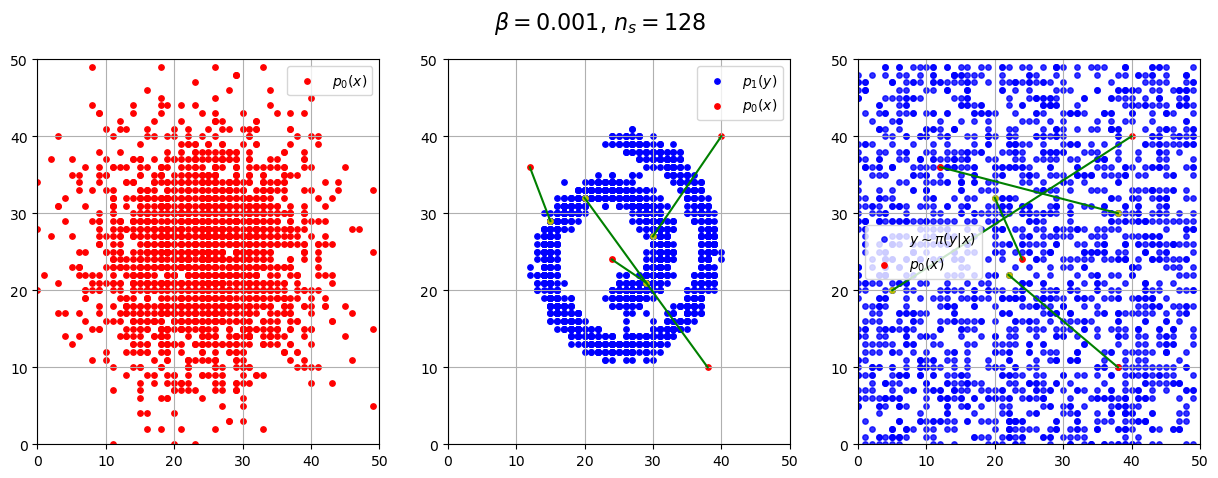

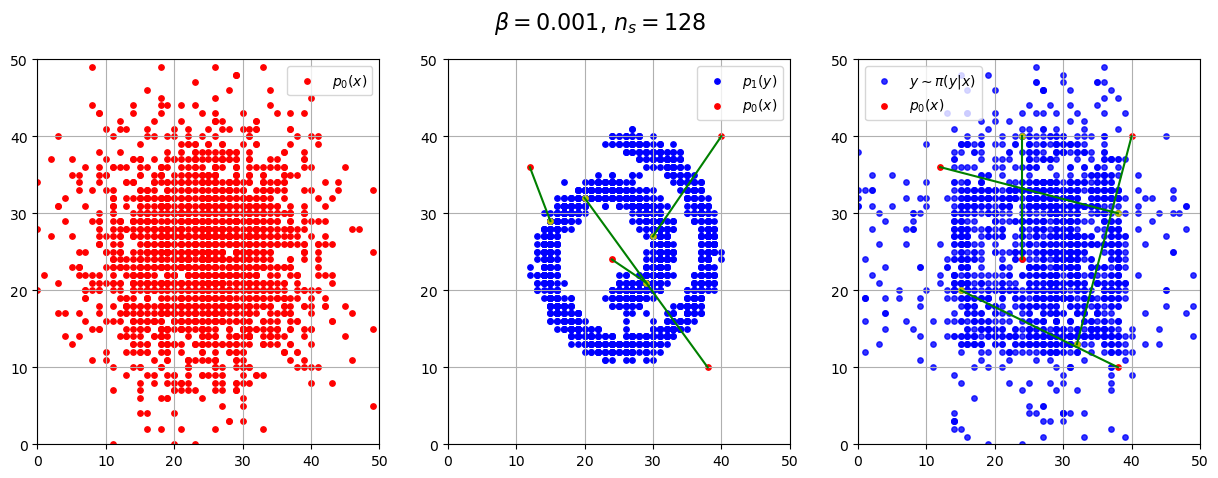

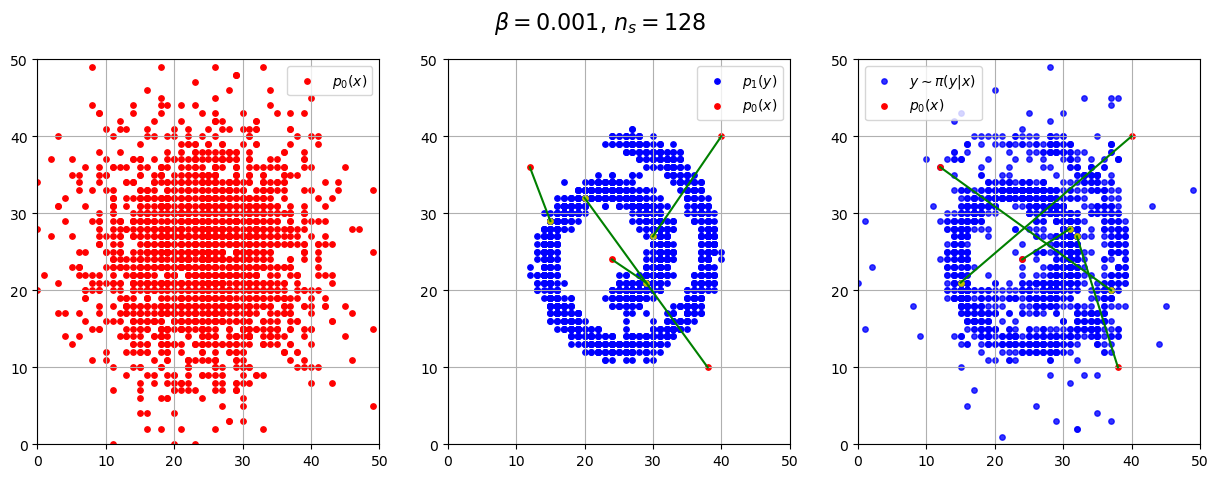

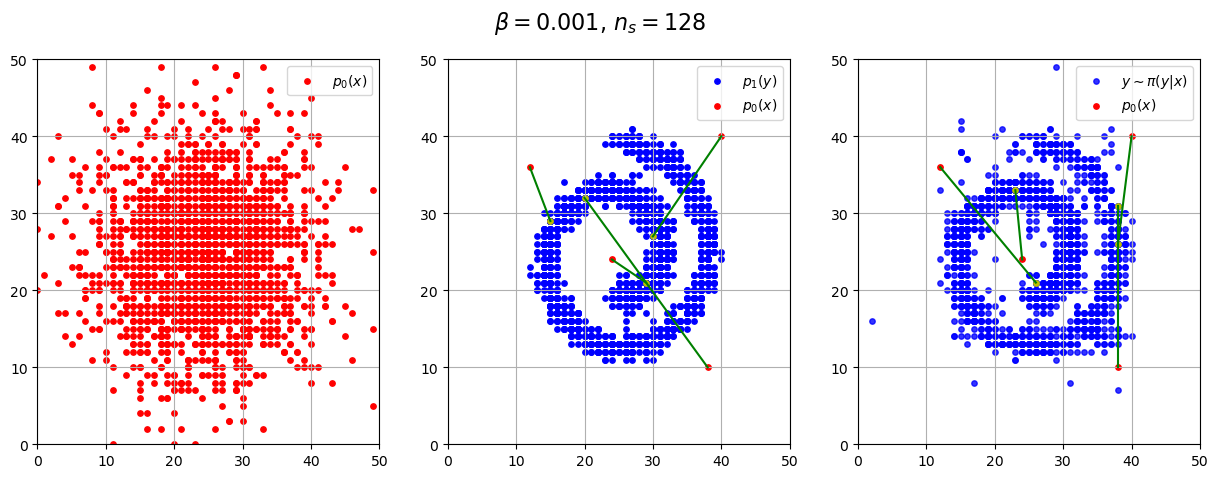

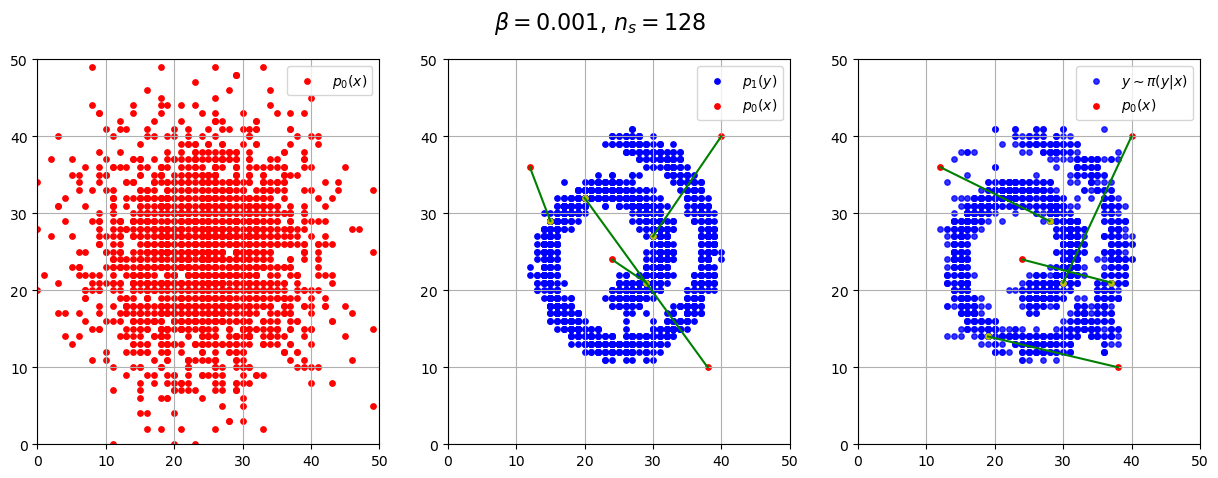

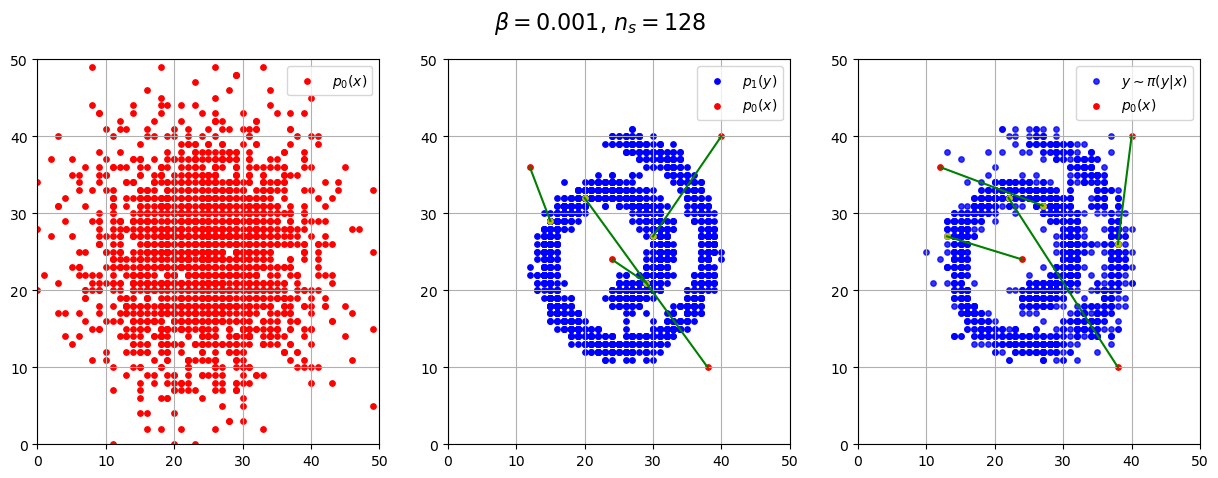

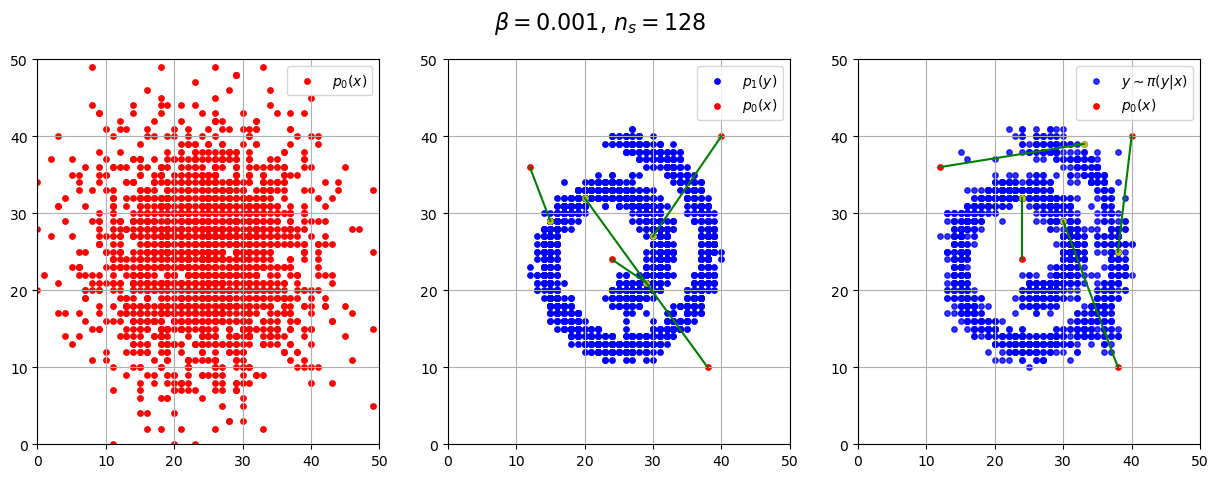

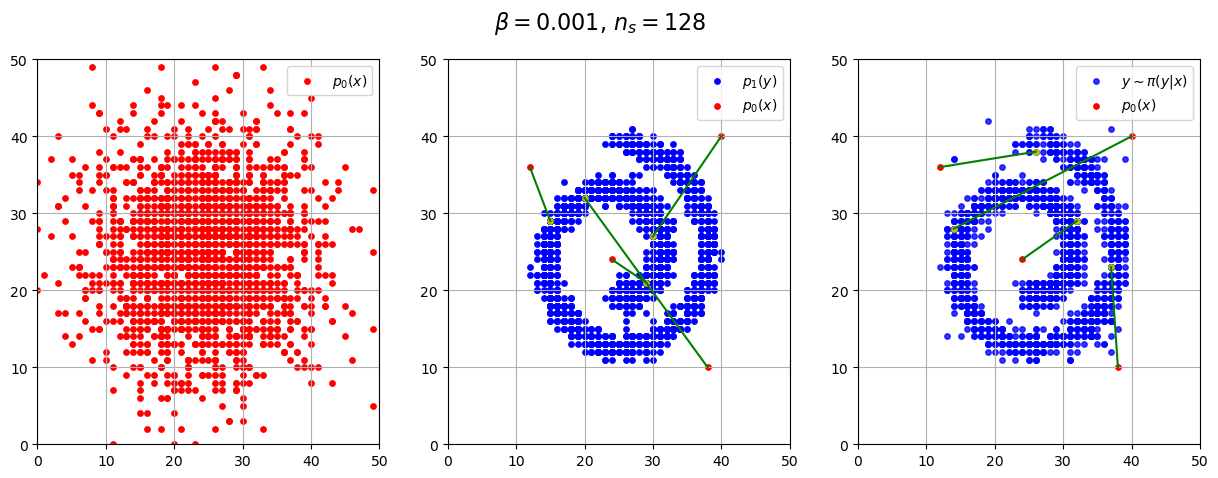

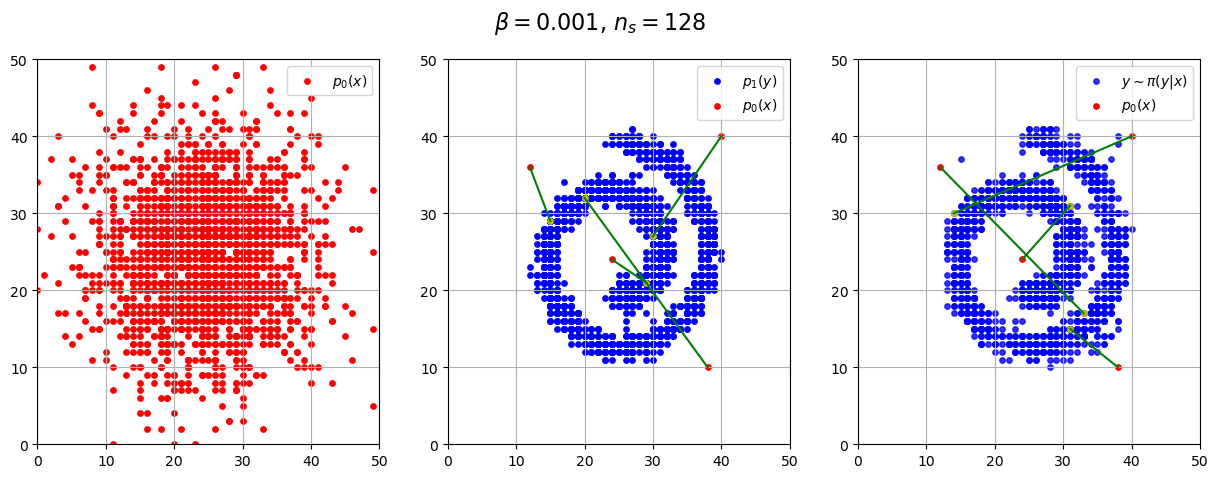

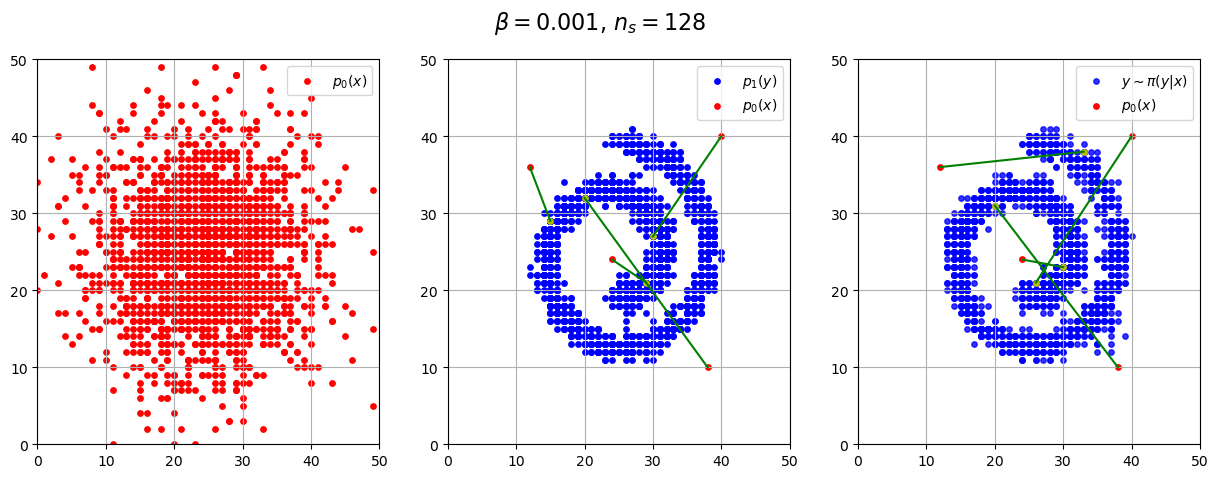

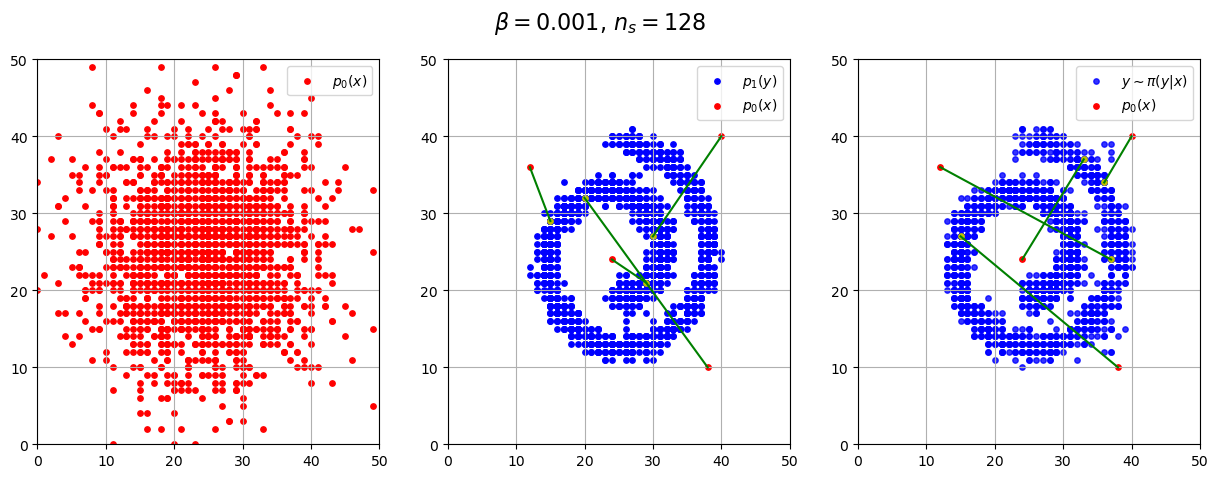

  0%|          | 0/200000 [00:00<?, ?it/s]

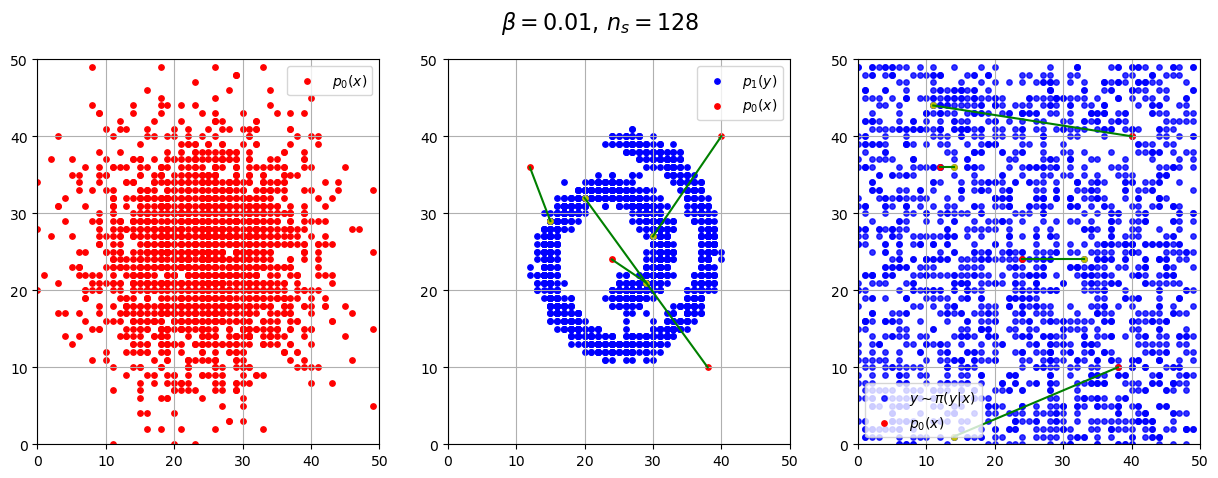

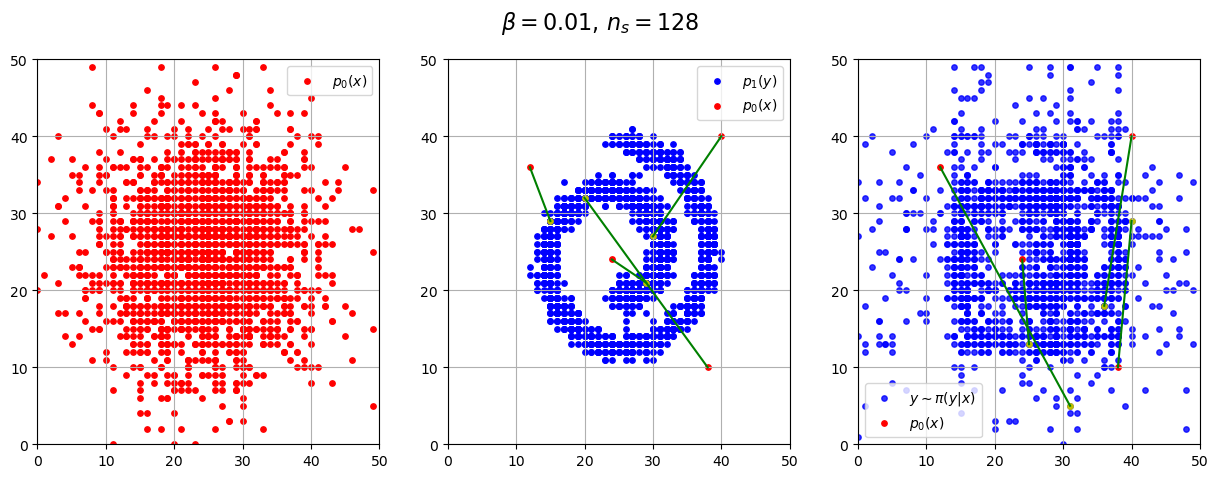

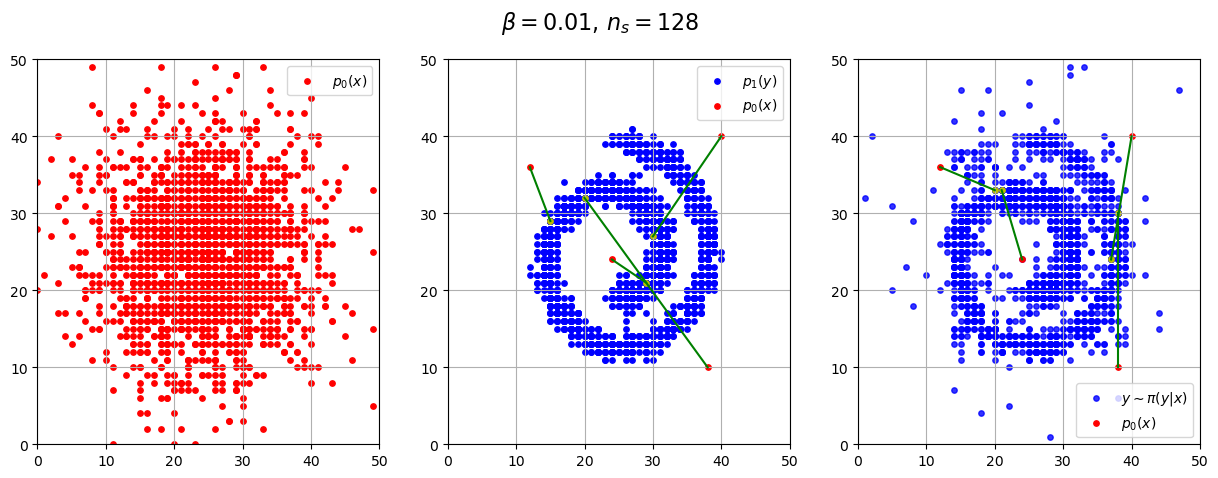

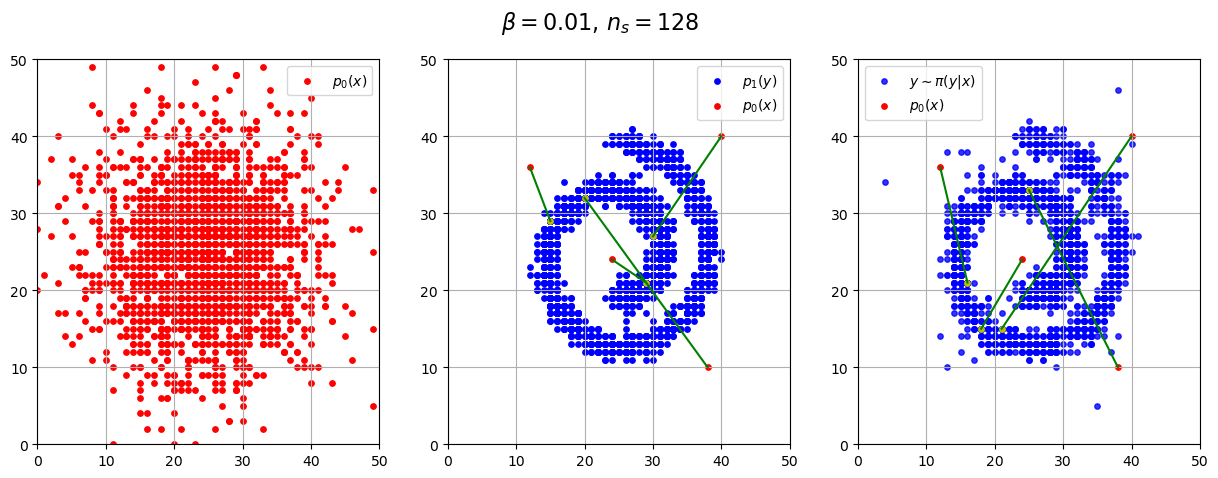

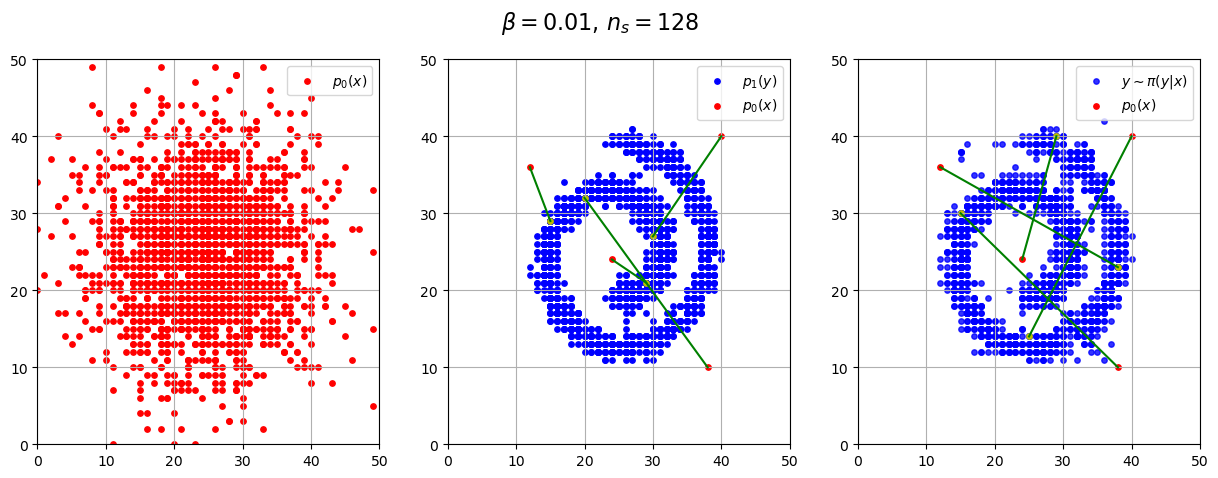

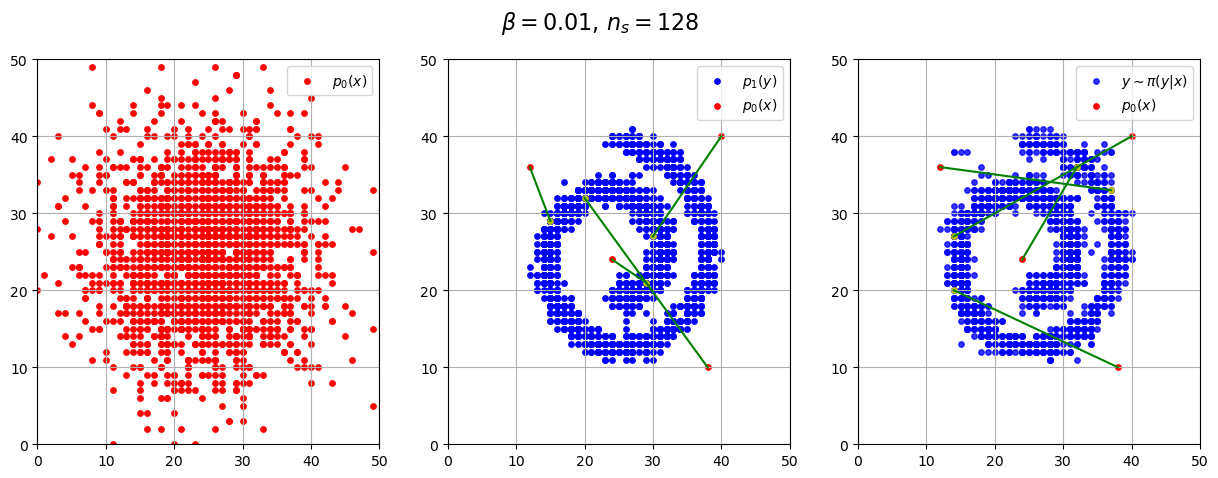

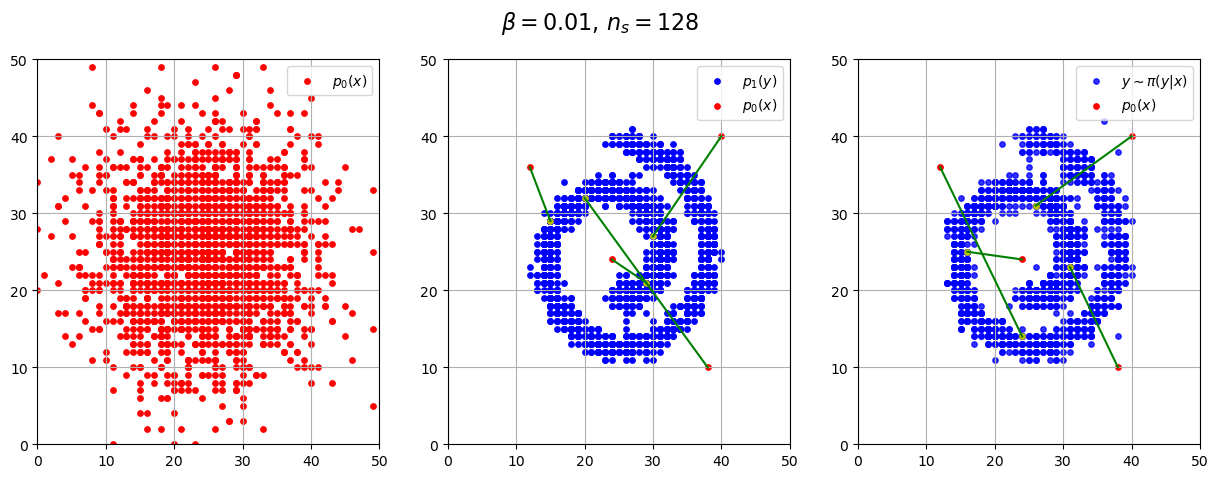

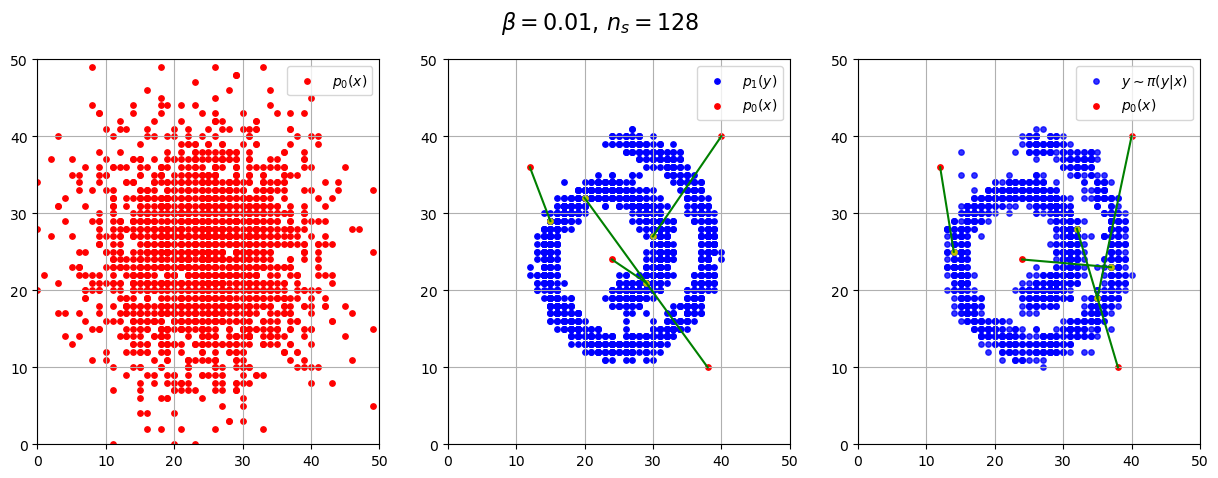

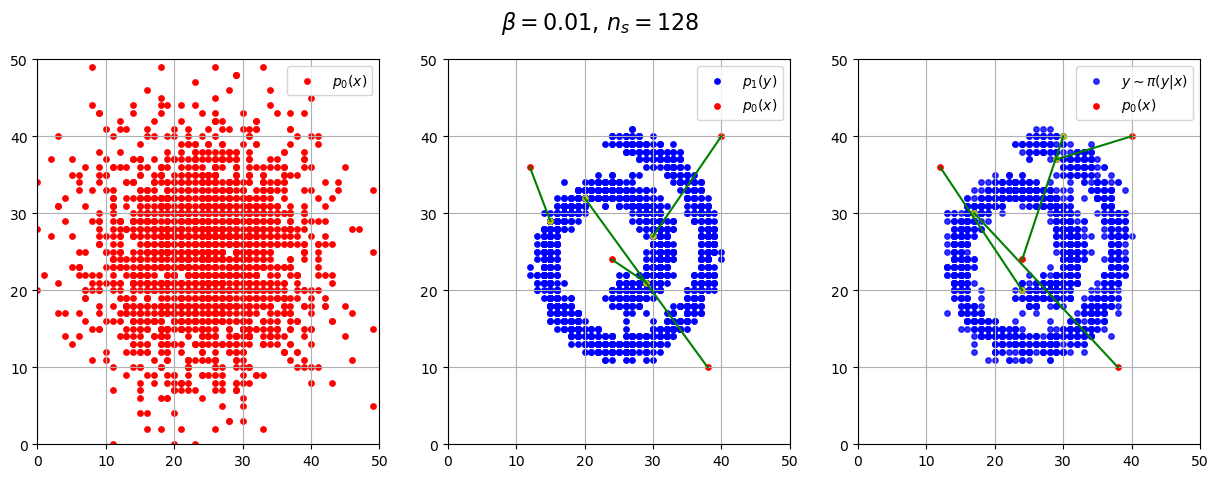

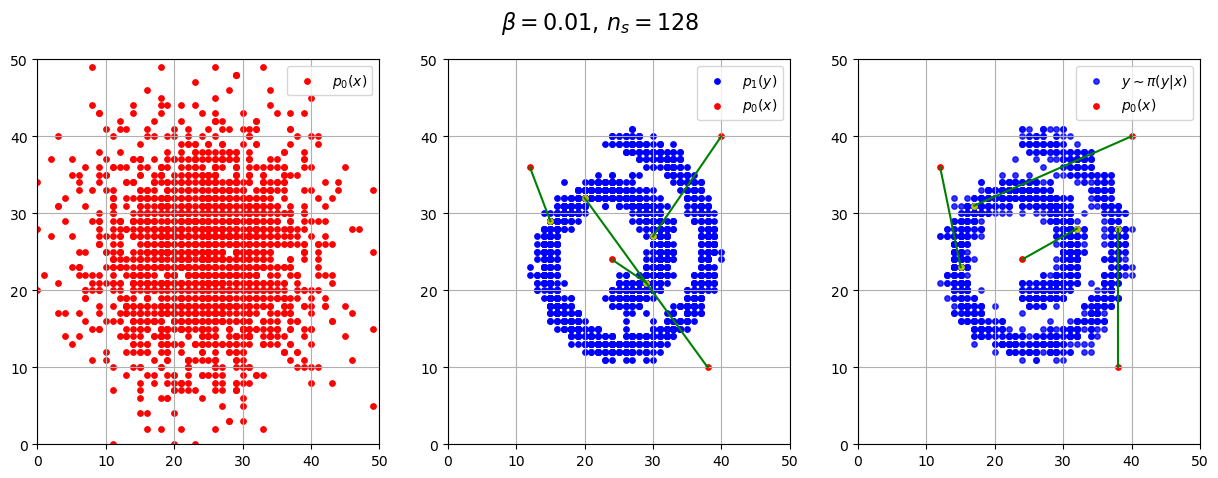

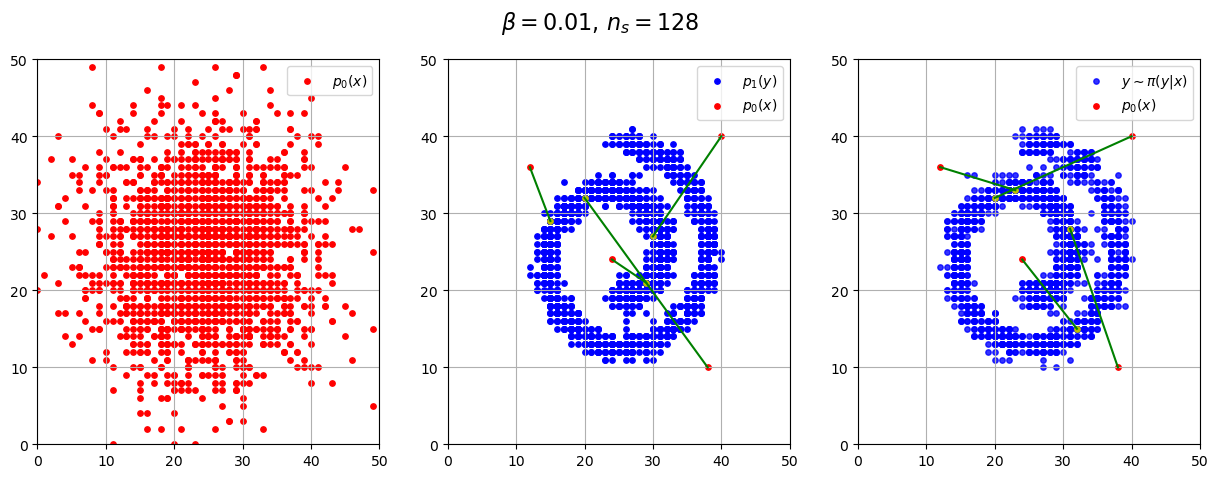

  0%|          | 0/200000 [00:00<?, ?it/s]

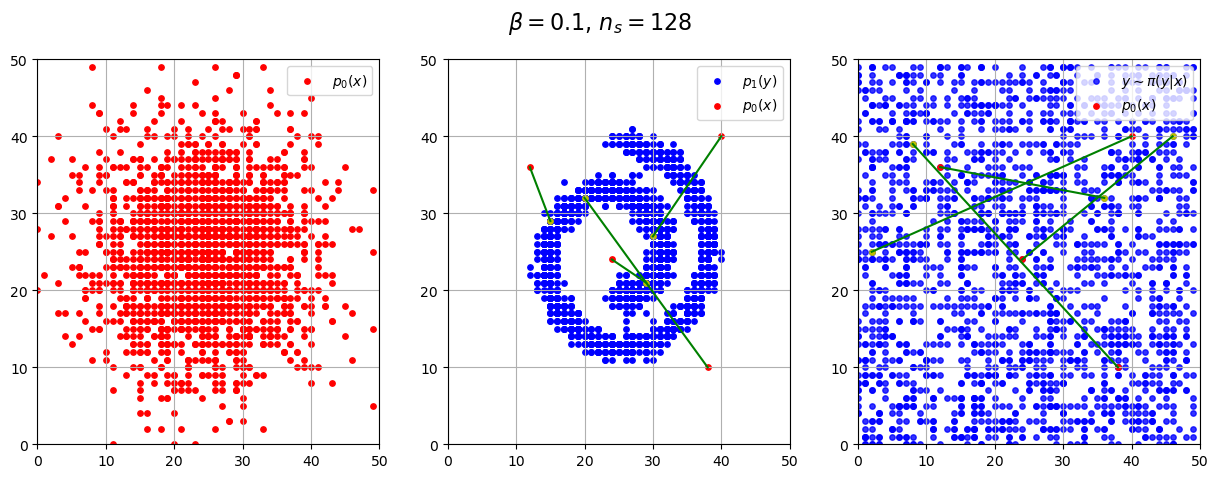

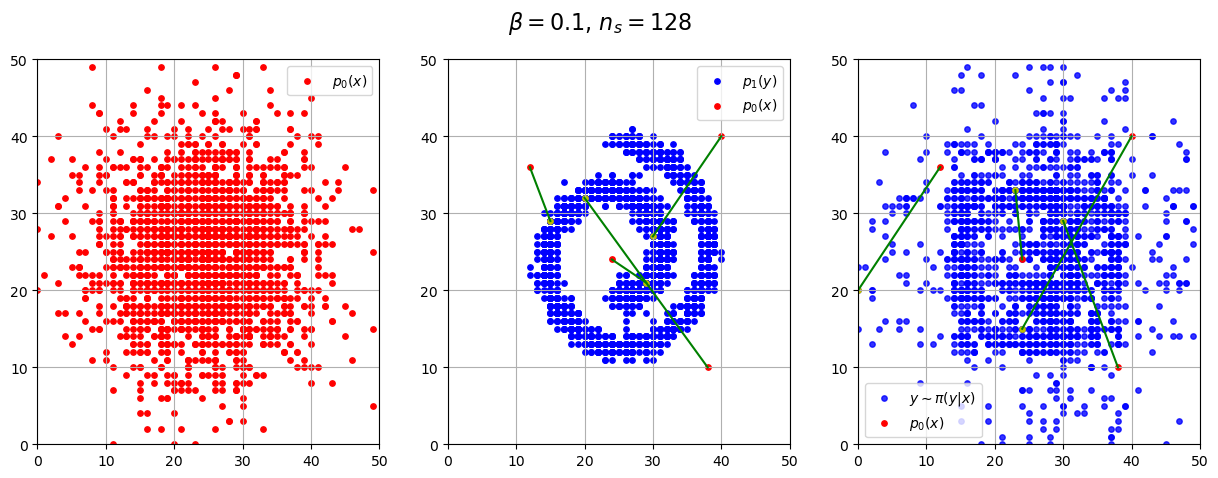

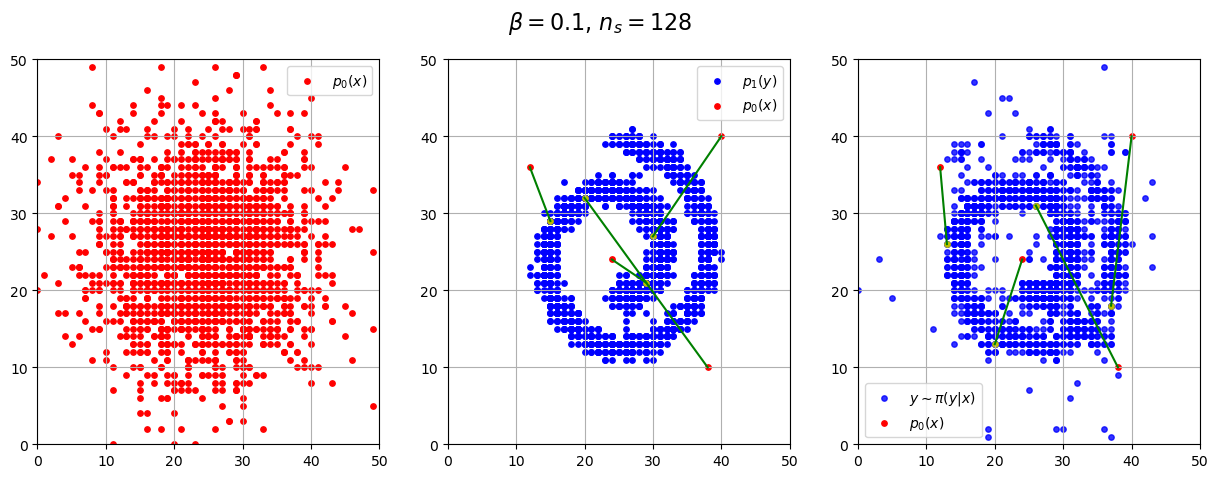

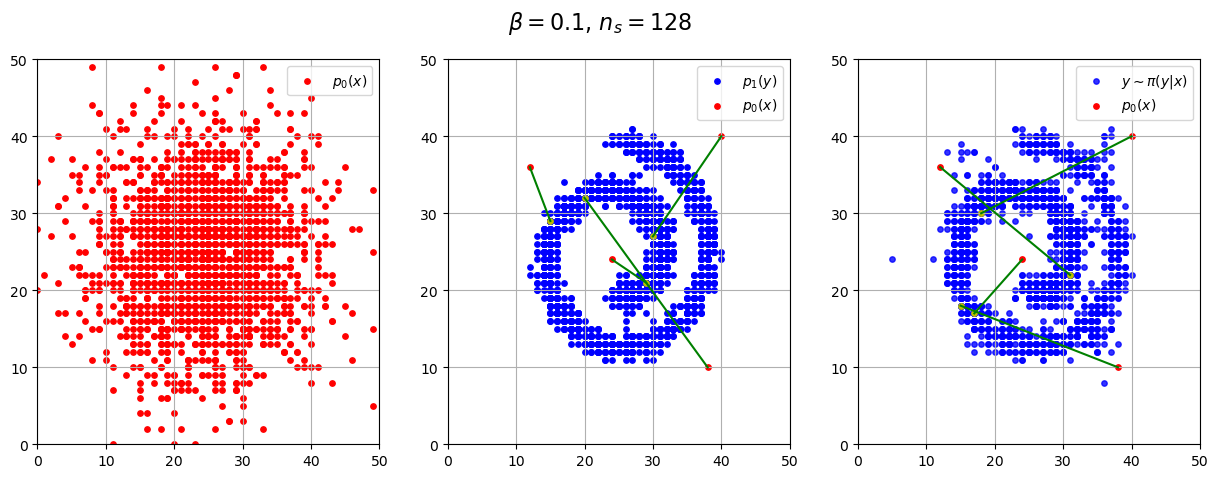

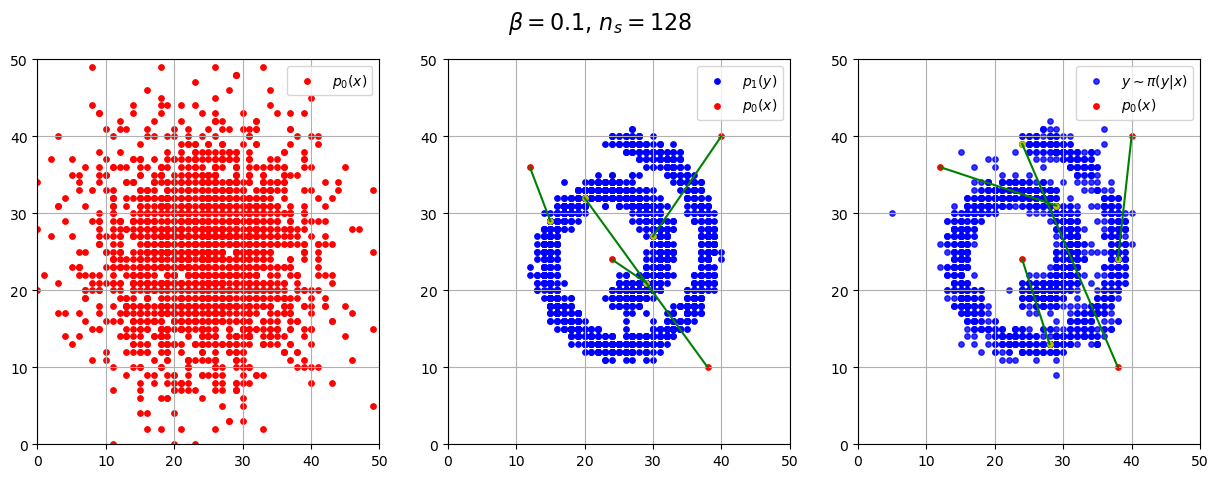

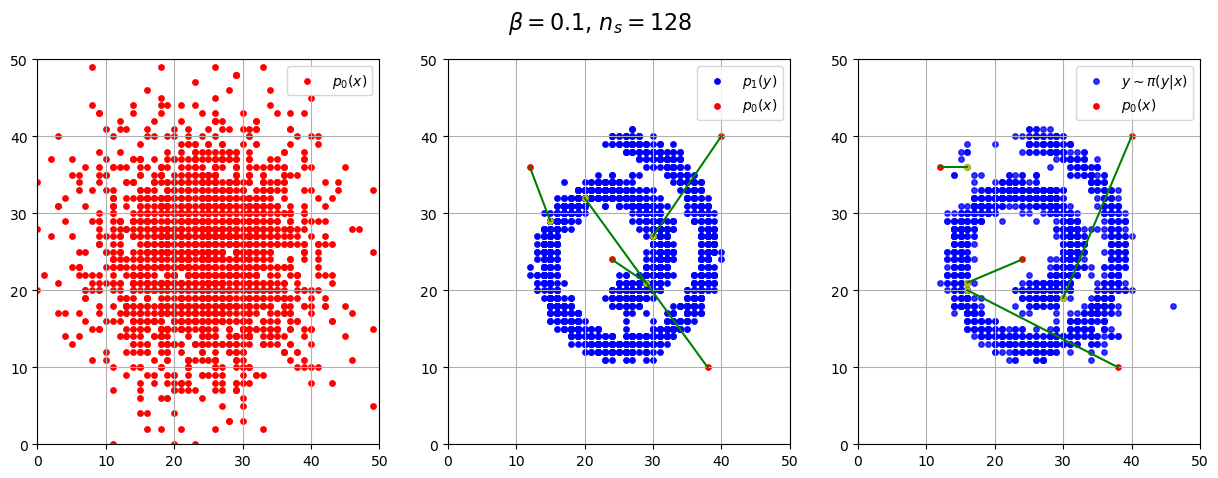

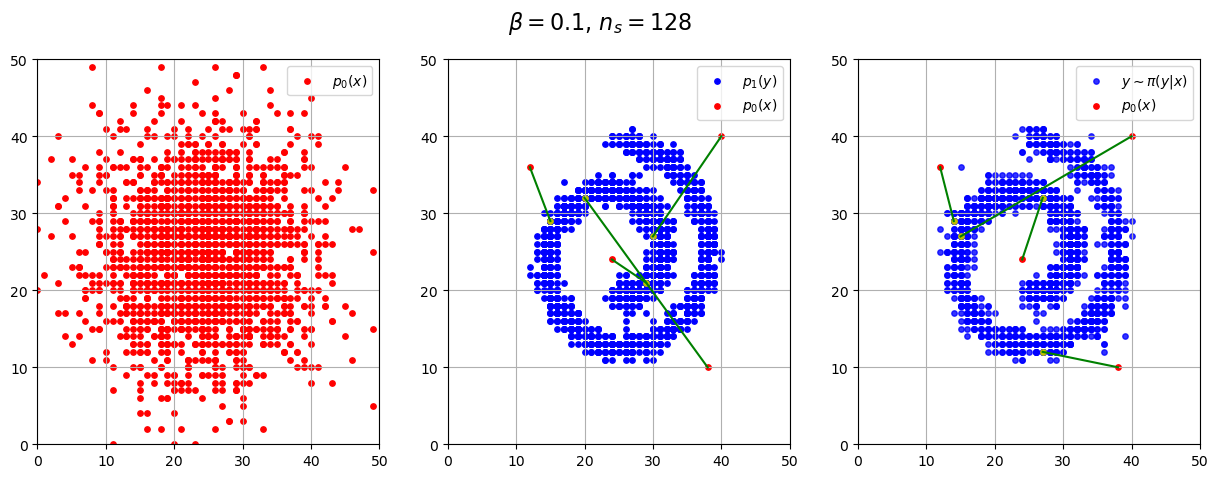

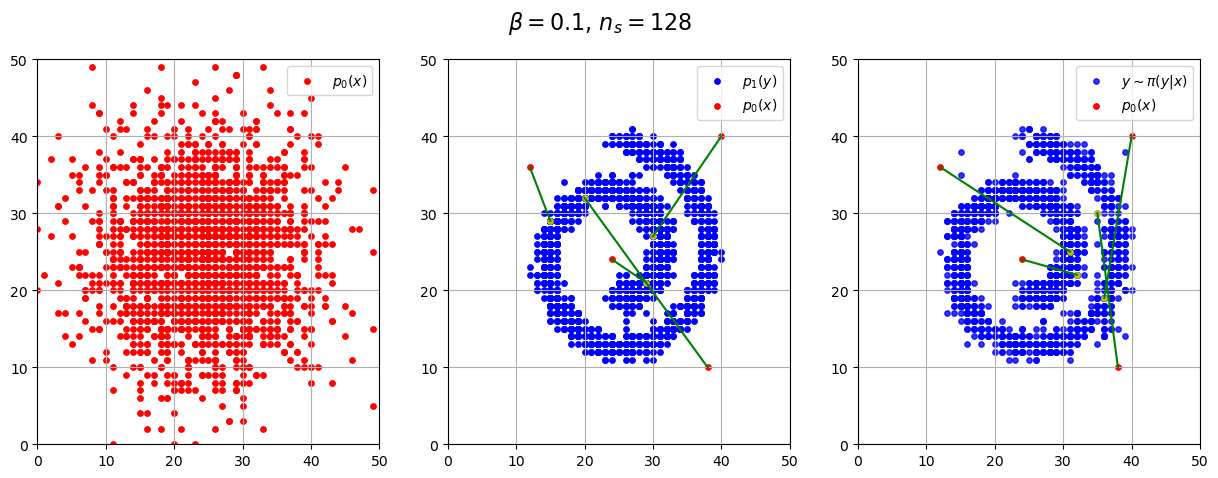

In [ ]:

xrange = [0, 50]  
yrange = [0, 50]  
N_TEST = 2000

if P0 == 'gaussian':
    X0_full = DiscreteGaussianDataset(num_samples=N_TEST, dim=DIM, num_categories=N_CAT, train=False).dataset
    X1_full = DiscreteSwissRollDataset(num_samples=N_TEST, num_categories=N_CAT).dataset
if P0 == 'uniform':
    X0_full = DiscreteUniformDataset(num_samples=N_TEST, dim=DIM, num_categories=N_CAT, train=False).dataset
    X1_full = DiscreteSwissRollDataset(num_samples=N_TEST, num_categories=N_CAT).dataset
if P0 == 'benchmark':
    X0_full = torch.load('X0_benchmark_dim_2.pt')
    X1_full = torch.load('X1_benchmark_dim_2.pt')
    
X0_test =X0_full[-N_TEST:].to(torch.int32).to(DEVICE)
X1_test =X1_full[-N_TEST:].to(torch.int32).to(DEVICE)

indices_plot = torch.tensor([0, 1, 2, 3], dtype=torch.int32)#torch.randint(0, len(X0_test), (50,))

for BETA in BETAS:
    exp_name = f'LightSB_D_beta({BETA})'
    wandb.init(name=exp_name, project=f'LightSB_D_P0_{P0}_PRIOR_TYPE({PRIOR_TYPE})' , config=config, mode=wandb_mode)
    D = LightSB_D(dim=DIM, n_cat=N_CAT, n_potentials=N_POTENTIALS, n_steps=N_STEPS, beta=BETA, 
                  prior_type=PRIOR_TYPE, distr_init='gaussian', device=DEVICE)
    
    #if INIT_BY_SAMPLES:
    #    D.init_r_by_samples(Y_sampler.sample(N_POTENTIALS))
    
    D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)
    for step in tqdm(range(N_EPOCHS)):
        D.train()
        D_opt.zero_grad()    

        if P0 == 'gaussian':
            X0 = DiscreteGaussianDataset(num_samples=BATCH_SIZE, dim=DIM, num_categories=N_CAT).dataset
            X1 = DiscreteSwissRollDataset(num_samples=BATCH_SIZE, num_categories=N_CAT).dataset
        
        if P0 == 'uniform':
            X0 = DiscreteUniformDataset(num_samples=BATCH_SIZE, dim=DIM, num_categories=N_CAT).dataset
            X1 = DiscreteSwissRollDataset(num_samples=BATCH_SIZE, num_categories=N_CAT).dataset
            
        if P0 == 'benchmark':
            indices = torch.randint(high=len(X0_full)-BATCH_SIZE, size=(BATCH_SIZE,))
            X0 = X0_full[indices]
            X1 = X1_full[indices]
            
        X0 = X0.to(torch.int32).to(DEVICE)
        X1 = X1.to(torch.int32).to(DEVICE)
    
        log_potential = D.get_log_v(X1)
        log_C         = D.get_log_c(X0)
        
        D_loss = (-log_potential + log_C).mean()
        wandb.log({'D_loss':D_loss.item()}, step=step)
        D_loss.backward()
        
        D_opt.step()    
    
        if step % 20000==0 or step==N_EPOCHS-1:
            D.eval()
            X1_pred = D.sample(X0_test).detach()#.cpu()
            fig = plot_samples(X0_test, X1_test, X1_pred, indices_plot, BETA, N_STEPS, xrange, yrange)
            
            img = fig2img(fig)
            wandb.log({'Plot source->target' : [wandb.Image(img)]}, step=step)
            
            plt.show()
        